In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


c:\Users\Bluewind\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def define_files():
    files = {
        "air_pollution_death": "data/air_pollution_death.csv",
        "transportation": 'data/road-transportation_country_emissions.csv',
        "coal": 'data/coal-mining_country_emissions.csv',
        "cropland": 'data/cropland-fires_country_emissions.csv',
        "residential_commercial": 'data/residential-and-commercial-onsite-fuel-usage_country_emissions.csv',
        "forest_clearing": 'data/forest-land-clearing_country_emissions.csv',
        "petrochemicals": 'data/petrochemicals_country_emissions.csv',
        "electricity_generation": 'data/electricity-generation_country_emissions.csv',
        "incineration_open_burning": 'data/incineration-and-open-burning-of-waste_country_emissions.csv',
        "health_expenditure": 'data/health-expenditure.csv',
        "urban_population": 'data/urban-population.csv'
    }
    return files

files = define_files()
files


{'air_pollution_death': 'data/air_pollution_death.csv',
 'transportation': 'data/road-transportation_country_emissions.csv',
 'coal': 'data/coal-mining_country_emissions.csv',
 'cropland': 'data/cropland-fires_country_emissions.csv',
 'residential_commercial': 'data/residential-and-commercial-onsite-fuel-usage_country_emissions.csv',
 'forest_clearing': 'data/forest-land-clearing_country_emissions.csv',
 'petrochemicals': 'data/petrochemicals_country_emissions.csv',
 'electricity_generation': 'data/electricity-generation_country_emissions.csv',
 'incineration_open_burning': 'data/incineration-and-open-burning-of-waste_country_emissions.csv',
 'health_expenditure': 'data/health-expenditure.csv',
 'urban_population': 'data/urban-population.csv'}

In [4]:
def find_common_country_codes(env_list, socio_list, files):
    env_codes = []
    for key in env_list:
        df = pd.read_csv(files[key])
        codes = set(df['iso3_country'].unique())
        env_codes.append(codes)
    common_env_codes = set.intersection(*env_codes) if env_codes else set()

    # Process socioeconomic files
    socio_codes = []
    for key in socio_list:
        df = pd.read_csv(files[key], skiprows=4)
        country_col = None
        for col in df.columns:
            if col.strip().replace(" ", "").lower() == "countrycode":
                country_col = col
                break
        if country_col is None:
            raise ValueError(f"Expected country code column not found in {files[key]}")
        codes = set(df[country_col].unique())
        socio_codes.append(codes)
    common_socio_codes = set.intersection(*socio_codes) if socio_codes else set()

    return sorted(list(common_env_codes.intersection(common_socio_codes)))

# Define environment and socio-economic factors
environment_factor_files_list = [
    'transportation', 'coal', 'cropland',
    'residential_commercial', 'forest_clearing',
    'petrochemicals', 'electricity_generation',
    'incineration_open_burning'
]
socioeconomic_files_list = ['health_expenditure', 'urban_population']

common_country_codes = find_common_country_codes(environment_factor_files_list, socioeconomic_files_list, files)
common_country_codes[:10]  # Display first 10 common country codes


['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT']

In [5]:
air_pollution_df = pd.read_csv(files["air_pollution_death"])
filtered_air_pollution_df = air_pollution_df[
    (air_pollution_df['SpatialDimValueCode'].isin(common_country_codes)) &
    (air_pollution_df['Period'] == 2018) &
    (air_pollution_df['Dim1'] == 'Both sexes')
]

filtered_air_pollution_df.to_csv('filtered_air_deaths.csv', index=False)
filtered_air_pollution_df.head()


,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
3294,AIR_41,Ambient air pollution attributable deaths,numeric,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2018,...,NaN,NaN,0.071,NaN,0.49,0 [0-0],NaN,NaN,EN,2024-10-02T16:00:00.000Z
3298,AIR_41,Ambient air pollution attributable deaths,numeric,AFR,Africa,Country,COM,Comoros,Year,2018,...,NaN,NaN,0.019,NaN,0.13,0 [0-0],NaN,NaN,EN,2024-10-02T16:00:00.000Z
3309,AIR_41,Ambient air pollution attributable deaths,numeric,AMR,Americas,Country,BHS,Bahamas,Year,2018,...,NaN,NaN,0.022,NaN,1.14,0 [0-1],NaN,NaN,EN,2024-10-02T16:00:00.000Z
3318,AIR_41,Ambient air pollution attributable deaths,numeric,WPR,Western Pacific,Country,KIR,Kiribati,Year,2018,...,NaN,NaN,0.000,NaN,1.23,0 [0-1],NaN,NaN,EN,2024-10-02T16:00:00.000Z
3323,AIR_41,Ambient air pollution attributable deaths,numeric,AMR,Americas,Country,VCT,Saint Vincent and the Grenadines,Year,2018,...,NaN,NaN,0.120,NaN,0.68,0 [0-1],NaN,NaN,EN,2024-10-02T16:00:00.000Z


In [6]:
environment_data = []
socioeconomic_data = []

for key in environment_factor_files_list:
    df = pd.read_csv(files[key])
    df_filtered = df[
        (df['iso3_country'].isin(common_country_codes)) &
        (df['start_time'] >= '2018-01-01 00:00:00')
    ]
    df_grouped = df_filtered.groupby('iso3_country', as_index=False)['emissions_quantity'].sum()
    df_grouped.rename(columns={'iso3_country': 'Country Code', 'emissions_quantity': key}, inplace=True)
    environment_data.append(df_grouped)

for key in socioeconomic_files_list:
    df = pd.read_csv(files[key], skiprows=4)
    df_filtered = df[df['Country Code'].isin(common_country_codes)]
    df_filtered = df_filtered[['Country Code', '2018']].rename(columns={'2018': key})
    socioeconomic_data.append(df_filtered)


In [7]:
deaths_by_country = filtered_air_pollution_df.groupby(['SpatialDimValueCode'])['FactValueNumeric'].sum().reset_index()
deaths_by_country.rename(columns={'SpatialDimValueCode': 'Country Code', 'FactValueNumeric': 'deaths'}, inplace=True)

environment_merged = environment_data[0]
for df in environment_data[1:]:
    environment_merged = pd.merge(environment_merged, df, on="Country Code", how="outer")

final_merged = environment_merged
for df in socioeconomic_data:
    final_merged = pd.merge(final_merged, df, on="Country Code", how="outer")

final_merged = pd.merge(final_merged, deaths_by_country, on="Country Code", how="outer")
final_merged_cleaned = final_merged.dropna()
final_merged_cleaned.to_csv('real_merged_data.csv', index=False)

final_merged_cleaned.head()


,Country Code,transportation,coal,cropland,residential_commercial,forest_clearing,petrochemicals,electricity_generation,incineration_open_burning,health_expenditure,urban_population,deaths
0,AFG,5.728724e+07,1.237991e+07,3.047164e+07,8.294334e+06,8.632059e+04,0.000000e+00,1.929000e+06,6.095110e+05,299.787491,9353296.0,44151.00
1,AGO,1.657005e+08,0.000000e+00,7.027087e+07,4.872556e+07,1.024659e+09,0.000000e+00,3.753900e+07,5.018776e+05,182.326689,20488542.0,16997.28
2,ALB,2.535625e+07,3.709218e+05,1.866232e+06,1.147137e+07,4.995076e+06,0.000000e+00,0.000000e+00,2.078827e+05,896.791354,1728969.0,6088.43
4,ARE,5.190228e+08,0.000000e+00,1.601377e+05,9.554346e+06,0.000000e+00,7.280612e+07,1.217688e+09,1.615316e+06,3002.587776,7908257.0,3599.55
5,ARG,6.409067e+08,1.997271e+05,7.706948e+08,5.821784e+08,4.487951e+08,1.150682e+07,7.590450e+08,2.238038e+06,2401.319013,40877099.0,34992.30


In [8]:
X = final_merged_cleaned.drop(columns=['Country Code', 'deaths'])
y = final_merged_cleaned['deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = xgb.XGBRegressor(
    n_estimators=600, learning_rate=0.07, max_depth=1, gamma=0.2,
    subsample=0.4, colsample_bytree=1, reg_alpha=1, reg_lambda=12.0,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")


Train R² Score: 0.7930
Test R² Score: 0.5600


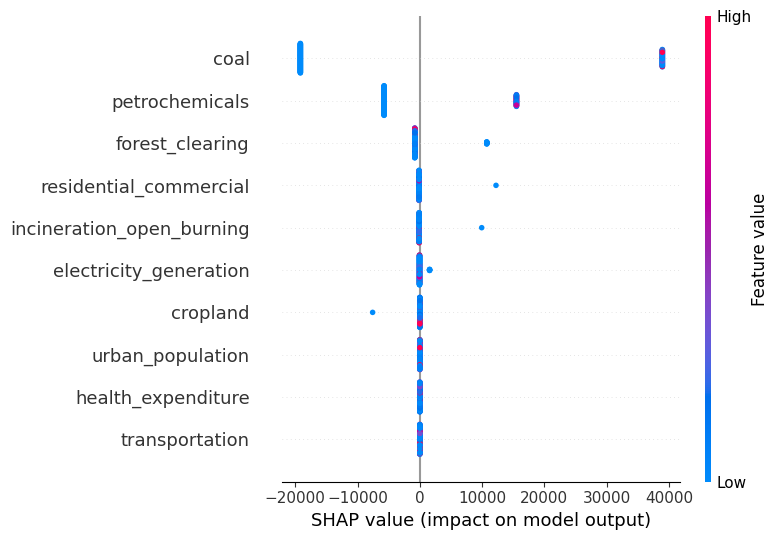

In [9]:
def generate_beeswarm_plot(X_train, model):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="dot")

generate_beeswarm_plot(X_train, xgb_model)


In [10]:
fig = px.scatter(final_merged_cleaned, x='health_expenditure', y='deaths', hover_data=['Country Code'])
fig.show()


In [ ]:
with open("coding_test_output.html", "w", encoding="utf-8") as f:
    f.write("""
    <html>
        <head><title>Air Pollution and Emissions Analysis</title></head>
        <body><h1>Air Pollution Deaths by Country</h1></body>
    </html>
    """)
